# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [70]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [71]:
# Setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Get data

In [72]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### Prepare data

In [73]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [74]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1492e401f0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [75]:
# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b1(weights=weights).to(device)
#model_0 # uncomment to output (it's very long)

In [76]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [77]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [78]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [79]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5, 
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0675 | train_acc: 0.5391 | test_loss: 0.9912 | test_acc: 0.7235
Epoch: 2 | train_loss: 0.9402 | train_acc: 0.7148 | test_loss: 0.9387 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.8565 | train_acc: 0.8555 | test_loss: 0.8468 | test_acc: 0.8475
Epoch: 4 | train_loss: 0.8441 | train_acc: 0.7578 | test_loss: 0.7714 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.7216 | train_acc: 0.7656 | test_loss: 0.7286 | test_acc: 0.8674
[INFO] Total training time: 7.419 seconds


### Make predictions on the entire test dataset with the model

In [80]:
try:
    from colorama import init, Fore, Back, Style
    # Initialize it so that it resets the color after each print statement
    init(autoreset=True)

except:
    print("Colorama library not found, attempting to install...")
    !pip install colorama
    from colorama import init, Fore, Back, Style
    # Initialize it so that it resets the color after each print statement
    init(autoreset=True)

In [81]:
# Import tqdm.auto
from tqdm.auto import tqdm

# Make predictions on the entire dataset with the model
test_preds = []
model_0.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="[PROGRESS]Making Predictions"):
        X, y = X.to(device), y.to(device)

        # Pass the data to the model and get logits
        logits = model_0(X)

        # Get the predicted label by finding the maximum along the columns
        pred_labels = logits.argmax(dim=1)

        

        # Add the predicted labels of each batch with torch.cat() to the test_preds list
        test_preds.append(pred_labels.cpu())

    # Concatenate all the labels together into one tensor using torch.cat()
    pred_labels_tensor = torch.cat(test_preds)        

[PROGRESS]Making Predictions:   0%|          | 0/3 [00:00<?, ?it/s]

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [82]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.0


In [83]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.0


In [84]:
# Loop through the test_dataloader and concatenate all the y's into a tensor
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth, test_truth.shape

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2]),
 torch.Size([75]))

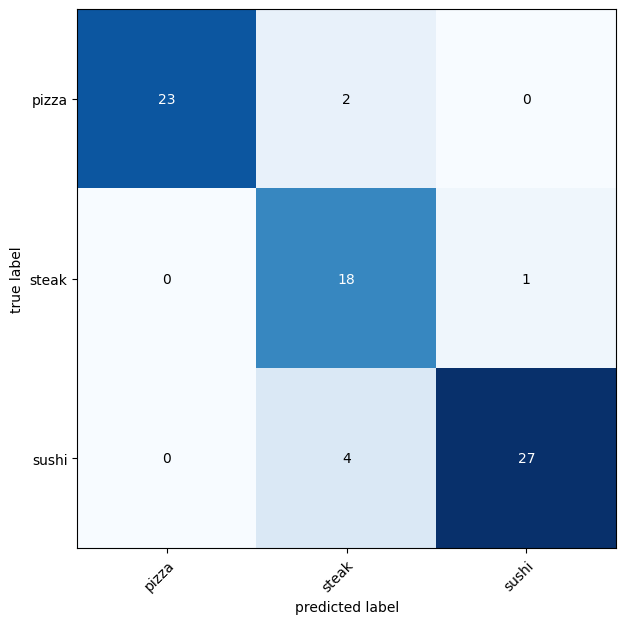

In [85]:
# TODO
from torcheval.metrics import MulticlassConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

# Setup confusion instance and compare predictions to target (y)
confmat = MulticlassConfusionMatrix(num_classes=len(class_names)) # Initialize the confusion matrix with a blank one
confmat.update(input=pred_labels_tensor,
               target=test_truth)
confmat_tensor = confmat.compute()

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                               figsize=(10,7))

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [92]:
import pandas as pd

# Get all test data paths
from pathlib import Path

# Iterate over every file in the test directory
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Grab the directory name of each file to get its associated label
test_labels = [path.parent.stem for path in test_data_paths]
test_labels[:17]

# Create a function to return a list of dictionaries with sample, label
def pred_and_store(test_paths, model, class_names, transform, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        # Create an empty dictionary to store info for each sample
        pred_dict = {}

        # Get class name
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        

        # Make a prediction on that path
        from PIL import Image
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(dim=0)

        model.eval()
        with torch.inference_mode():
            pred_logits = model(transformed_image.to(device))
            pred_probs = pred_logits.softmax(dim=1)
            pred_label = pred_probs.argmax(dim=1)
            pred_class = class_names[pred_label]
    
            # Make sure things on the dictionary are on the CPU
            pred_dict["pred_prob"] = float(pred_probs.max().cpu())
            pred_dict["pred_class"] = pred_class
    
            # Does the pred math the true label
        pred_dict["correct"] = class_name == pred_class

        #Add the dictionary to the list of preds
        # We will build a dataframe out of the list and be able to sort through it
        test_pred_list.append(pred_dict)

    return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
               model=model_0,
               transform=simple_transform,
               class_names=class_names,
               device=device)

  0%|          | 0/75 [00:00<?, ?it/s]

In [93]:
# Grab pandas library
import pandas as pd

test_pred_df = pd.DataFrame(test_pred_dicts)
test_pred_df = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False])
top_5_most_wrong = test_pred_df.head()
top_5_most_wrong

,class_name,pred_prob,pred_class,correct
60,steak,0.453667,sushi,False
28,sushi,0.453288,steak,False
20,sushi,0.437900,steak,False
39,pizza,0.412996,steak,False
35,pizza,0.392207,steak,False


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [99]:
# TODO: Get an image of pizza/steak/sushi
import requests
custom_image_url = "https://www.happyfoodstube.com/wp-content/uploads/2016/03/homemade-sushi-picture.jpg"

with open("custom_sushi.jpg", "wb") as f:
    request = requests.get(custom_image_url)
    f.write(request.content)
    print("Download successful!")

Download successful!


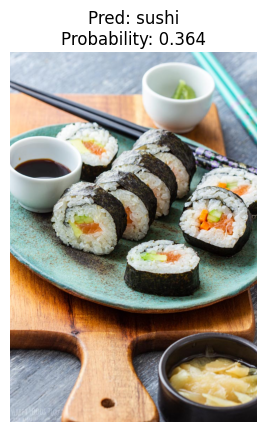

In [100]:
# Make a function to pred and plot images
from PIL import Image

def pred_and_plot(image_path: str,
                  model: torch.nn.Module,
                  class_names,
                  transform: torchvision.transforms,
                  device=device):
    # Open image
    image = Image.open(image_path)

    # Transform image
    transformed_image = transform(image).to(device)

    # Predict what the image is
    model.eval()
    with torch.inference_mode():
        image_logit = model(transformed_image.unsqueeze(0))
        image_probs = image_logit.softmax(dim=1)
        image_label = image_probs.argmax(dim=1)
        image_class = class_names[image_label]

    # Plot the image
    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {image_class}\nProbability: {image_probs.max():.3f}")
    plt.axis(False);
    
pred_and_plot(image_path="custom_sushi.jpg",
              model=model_0,
              class_names=class_names,
              transform=simple_transform)

Download successful!


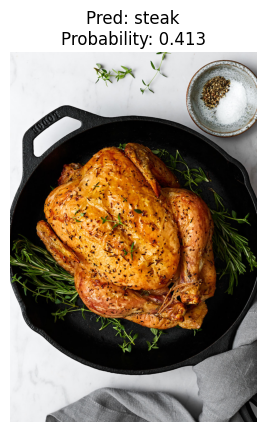

In [101]:
# TODO: Get an image of not pizza/steak/sushi
roasted_chicken_url = "https://i2.wp.com/www.downshiftology.com/wp-content/uploads/2022/10/Roast-Chicken-5.jpg"

with open("roasted_chicken.jpg", "wb") as f:
    request = requests.get(roasted_chicken_url)
    f.write(request.content)
    print("Download successful!")

pred_and_plot(image_path="roasted_chicken.jpg",
              model=model_0,
              class_names=class_names,
              transform=simple_transform)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [102]:
# TODO: Recreate a new model
import torchvision

# Get weights for pre-trained model and create a new model
weights = torchvision.models.EfficientNet_B1_Weights
model_1 = torchvision.models.efficientnet_b1(weights=weights).to(device)

# Turn off the gradients in the base layer model
for param in model_1.features.parameters():
    param.requires_grad = False

/home/gerald/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Exception ignored in: <function _ConnectionBase.__del__ at 0x7f170a7fed40>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [66]:
# Print summary with torchinfo
summary(model=model_1,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width])
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [103]:
# Fetch classifier layer to re-create and modify it below
model_1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [115]:
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)
model_1.classifier
model_1.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [116]:
# TODO: Train the model for 10 epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=10,
                       device=device)
results

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0257 | train_acc: 0.4258 | test_loss: 0.8959 | test_acc: 0.7424
Epoch: 2 | train_loss: 0.8283 | train_acc: 0.6562 | test_loss: 0.8450 | test_acc: 0.7017
Epoch: 3 | train_loss: 0.7627 | train_acc: 0.6562 | test_loss: 0.7136 | test_acc: 0.8665
Epoch: 4 | train_loss: 0.6631 | train_acc: 0.7773 | test_loss: 0.6029 | test_acc: 0.9167
Epoch: 5 | train_loss: 0.5823 | train_acc: 0.7852 | test_loss: 0.6280 | test_acc: 0.8352
Epoch: 6 | train_loss: 0.5247 | train_acc: 0.9141 | test_loss: 0.5592 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.4723 | train_acc: 0.9297 | test_loss: 0.5867 | test_acc: 0.8153
Epoch: 8 | train_loss: 0.5025 | train_acc: 0.8125 | test_loss: 0.5952 | test_acc: 0.8153
Epoch: 9 | train_loss: 0.4331 | train_acc: 0.9531 | test_loss: 0.5200 | test_acc: 0.8258
Epoch: 10 | train_loss: 0.4018 | train_acc: 0.9492 | test_loss: 0.4904 | test_acc: 0.8759


{'train_loss': [1.025696486234665,
  0.8282666653394699,
  0.7626723647117615,
  0.6631185561418533,
  0.5823257714509964,
  0.524683803319931,
  0.4722739942371845,
  0.5024659000337124,
  0.4330591280013323,
  0.40181238390505314],
 'train_acc': [0.42578125,
  0.65625,
  0.65625,
  0.77734375,
  0.78515625,
  0.9140625,
  0.9296875,
  0.8125,
  0.953125,
  0.94921875],
 'test_loss': [0.895876149336497,
  0.8450068632761637,
  0.7135861118634542,
  0.6029430429140726,
  0.6279503703117371,
  0.559224009513855,
  0.5867020984490713,
  0.5951986114184061,
  0.5199726720650991,
  0.4903525908788045],
 'test_acc': [0.7424242424242425,
  0.7017045454545454,
  0.8664772727272728,
  0.9166666666666666,
  0.8352272727272728,
  0.8759469696969697,
  0.8153409090909092,
  0.8153409090909092,
  0.8257575757575758,
  0.8759469696969697]}

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [117]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [118]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [119]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1492fd3be0>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:
# Fetch weights and create model and do not freeze all layers
weights = torchvision.models.EfficientNet_B1_Weights
model_2 = torchvision.models.efficientnet_b1(weights=weights).to(device)

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)

# Change the output layer
model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)
model_2.to(device)

### Train a model with 20% of the data

In [127]:
# TODO
results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6187 | train_acc: 0.8042 | test_loss: 0.1277 | test_acc: 0.9568
Epoch: 2 | train_loss: 0.2292 | train_acc: 0.9375 | test_loss: 0.1696 | test_acc: 0.9563
Epoch: 3 | train_loss: 0.1620 | train_acc: 0.9437 | test_loss: 0.1051 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.1196 | train_acc: 0.9396 | test_loss: 0.1197 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.2558 | train_acc: 0.9146 | test_loss: 0.1800 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.1163 | train_acc: 0.9750 | test_loss: 0.0978 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.0513 | train_acc: 0.9958 | test_loss: 0.0684 | test_acc: 0.9812
Epoch: 8 | train_loss: 0.0172 | train_acc: 0.9958 | test_loss: 0.0840 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.0722 | train_acc: 0.9479 | test_loss: 0.1374 | test_acc: 0.9500
Epoch: 10 | train_loss: 0.0964 | train_acc: 0.9646 | test_loss: 0.3606 | test_acc: 0.8972


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [131]:
# Get weights create model
weights = torchvision.models.EfficientNet_B1_Weights
model_3 = torchvision.models.efficientnet_b1(weights=weights)

# Create the transform from the weights automatically
auto_transform = weights.transforms()
auto_transform

/home/gerald/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /home/gerald/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████████████████████████████████| 74.5M/74.5M [00:08<00:00, 9.62MB/s]


RuntimeError: invalid hash value (expected "7eb33cd5", got "23ab8bcd5bdbef61a7a43b91adcad81f622fd7f36fb4935a569828d77888c44e")